In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/kcah/Documents/code-repo/air-quality-prediction
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [6]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_HELSINKI_JSON").value
locations = json.loads(location_str)
# Pick the first location object as the target, or modify as needed
location = locations[0]
country = location['country']
city = location['city']
street = location['street']

print(f"Found {len(locations)} location(s) to process:")
for i, loc in enumerate(locations, 1):
    print(f"  {i}. {loc.get('street', 'unknown')} - {loc.get('city', 'unknown')}")

2025-11-18 12:08:32,831 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 12:08:32,834 INFO: Initializing external client
2025-11-18 12:08:32,834 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 12:08:34,437 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279136
Found 4 location(s) to process:
  1. kluuvi - helsinki
  2. kallio-2 - helsinki
  3. mannerheimintie - helsinki
  4. vartiokyla-huivipolku - helsinki


In [7]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_helsinki',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_helsinki',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [10]:
# Select features for training data.
# Include 'street' in the selection so we can split train/test separately for each street
selected_features = air_quality_fg.select(['pm25', 'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'date', 'street']).join(weather_fg.select_features(), on=['city'])

2025-11-18 12:12:33,959 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'rain_sum'] from feature group `weather_helsinki` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [12]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_helsinki_fv',
    description="weather features with air quality as the target with extended aq and weather features",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279136/fs/1265746/fv/air_quality_helsinki_fv/version/1


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date.

**Important:** We split train/test separately for each street to prevent data leakage and get more realistic evaluation metrics per location.

In [13]:
start_date_test_data = "2025-10-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [19]:
# Get all data first (we'll split by street manually)
X_all, y_all = feature_view.training_data()

# Convert date column to datetime and remove timezone to match test_start format
X_all['date'] = pd.to_datetime(X_all['date']).dt.tz_localize(None)

# Split train/test separately for each street to prevent data leakage
# This ensures that each street's test data is completely separate from its training data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Get unique streets
unique_streets = X_all['street'].unique()
print(f"Splitting train/test separately for {len(unique_streets)} street(s): {list(unique_streets)}")

for street in unique_streets:
    # Filter data for this street
    street_mask = X_all['street'] == street
    X_street = X_all[street_mask].copy()
    y_street = y_all[street_mask].copy()
    
    # Split by date for this street
    train_mask = X_street['date'] < test_start
    test_mask = X_street['date'] >= test_start
    
    X_train_street = X_street[train_mask]
    X_test_street = X_street[test_mask]
    y_train_street = y_street[train_mask]
    y_test_street = y_street[test_mask]
    
    print(f"  {street}: train={len(X_train_street)}, test={len(X_test_street)}")
    
    X_train_list.append(X_train_street)
    X_test_list.append(X_test_street)
    y_train_list.append(y_train_street)
    y_test_list.append(y_test_street)

# Combine all streets
X_train = pd.concat(X_train_list, ignore_index=True)
X_test = pd.concat(X_test_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
y_test = pd.concat(y_test_list, ignore_index=True)

print(f"\nTotal: train={len(X_train)}, test={len(X_test)}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.28s) 
2025-11-18 12:22:23,630 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.
Splitting train/test separately for 4 street(s): ['kluuvi', 'kallio-2', 'mannerheimintie', 'vartiokyla-huivipolku']
  kluuvi: train=4123, test=49
  kallio-2: train=4114, test=49
  mannerheimintie: train=4120, test=49
  vartiokyla-huivipolku: train=3998, test=49

Total: train=16355, test=196


In [20]:
# Display training data separated by street
print("Training data separated by street:")
print("="*60)
for street in unique_streets:
    X_train_street = X_train[X_train['street'] == street]
    print(f"\n{street}: {len(X_train_street)} samples")
    print(X_train_street.head())
    print(f"  Date range: {X_train_street['date'].min()} to {X_train_street['date'].max()}")
    print("-"*60)

# Also show combined summary
print(f"\nCombined X_train: {len(X_train)} total samples")
print(f"Columns: {list(X_train.columns)}")

Training data separated by street:

kluuvi: 4123 samples
   pm25_lag_1d  pm25_lag_2d  pm25_lag_3d       date  street  \
0          NaN          NaN          NaN 2014-05-02  kluuvi   
1         25.0          NaN          NaN 2014-05-03  kluuvi   
2         15.0         25.0          NaN 2014-05-04  kluuvi   
3         16.0         15.0         25.0 2014-05-05  kluuvi   
4         21.0         16.0         15.0 2014-05-06  kluuvi   

   temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0             4.351167                2.1           16.203999   
1             4.938667                0.9           19.586117   
2             3.959500                6.7           17.673029   
3             4.142833                4.3           20.380579   
4             4.921999                0.7           13.339445   

   wind_direction_10m_dominant  rain_sum  
0                   293.160156       2.1  
1                   255.580917       0.9  
2                   291.862366       6.4  
3

In [21]:
# Prepare features per street for separate model training
# We'll train a separate model for each street to learn street-specific patterns
street_models = {}
street_predictions = {}
street_test_data = {}

# Drop 'date' and 'street' columns before training (street is used only for splitting)
# Prepare features for each street separately
for street in unique_streets:
    # Get train/test data for this street
    X_train_street = X_train[X_train['street'] == street].copy()
    X_test_street = X_test[X_test['street'] == street].copy()
    y_train_street = y_train[X_train['street'] == street]
    y_test_street = y_test[X_test['street'] == street]
    
    # Drop 'date' and 'street' columns for training
    X_train_features = X_train_street.drop(columns=['date', 'street'])
    X_test_features = X_test_street.drop(columns=['date', 'street'])
    
    # Store for later use
    street_models[street] = {
        'X_train': X_train_features,
        'y_train': y_train_street,
        'X_test': X_test_features,
        'y_test': y_test_street,
        'X_test_with_meta': X_test_street[['date', 'street']].copy()
    }
    
    print(f"Prepared data for {street}: train={len(X_train_features)}, test={len(X_test_features)}")

Prepared data for kluuvi: train=4123, test=49
Prepared data for kallio-2: train=4114, test=49
Prepared data for mannerheimintie: train=4120, test=49
Prepared data for vartiokyla-huivipolku: train=3998, test=49


In [23]:
y_train_street

,pm25
12357,23.0
12358,18.0
12359,17.0
12360,17.0
12361,25.0
...,...
16350,9.0
16351,9.0
16352,9.0
16353,11.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [24]:
# Train a separate XGBoost model for each street
print("Training separate models for each street...")
print("="*60)

for street in unique_streets:
    print(f"\nTraining model for {street}...")
    
    # Create and train model for this street
    xgb_regressor = XGBRegressor()
    xgb_regressor.fit(
        street_models[street]['X_train'], 
        street_models[street]['y_train']
    )
    
    # Store the trained model
    street_models[street]['model'] = xgb_regressor
    
    # Make predictions on test set
    y_pred = xgb_regressor.predict(street_models[street]['X_test'])
    
    # Store predictions with metadata
    street_predictions[street] = y_pred
    street_test_data[street] = street_models[street]['y_test'].copy()
    
    # Calculate metrics for this street
    mse = mean_squared_error(street_models[street]['y_test'].iloc[:, 0], y_pred)
    r2 = r2_score(street_models[street]['y_test'].iloc[:, 0], y_pred)
    
    print(f"  Train samples: {len(street_models[street]['X_train'])}")
    print(f"  Test samples: {len(street_models[street]['X_test'])}")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)


Training separate models for each street...

Training model for kluuvi...
  Train samples: 4123
  Test samples: 49
  MSE: 74.5744
  R²: 0.4039

Training model for kallio-2...
  Train samples: 4114
  Test samples: 49
  MSE: 77.0744
  R²: 0.2361

Training model for mannerheimintie...
  Train samples: 4120
  Test samples: 49
  MSE: 72.0926
  R²: 0.3780

Training model for vartiokyla-huivipolku...
  Train samples: 3998
  Test samples: 49
  MSE: 58.8905
  R²: 0.1840

All models trained successfully!


In [25]:
# Evaluate model performance per street (using separate models)
print("\n" + "="*60)
print("Per-Street Evaluation Metrics (Separate Models)")
print("="*60)

# Calculate metrics for each street using their respective models
street_metrics = []
all_predictions = []

for street in unique_streets:
    y_test_street = street_models[street]['y_test'].iloc[:, 0]
    y_pred_street = street_predictions[street]
    
    street_mse = mean_squared_error(y_test_street, y_pred_street)
    street_r2 = r2_score(y_test_street, y_pred_street)
    
    street_metrics.append({
        'street': street,
        'test_samples': len(y_test_street),
        'MSE': street_mse,
        'R2': street_r2
    })
    
    # Combine predictions with metadata for visualization
    df_street = street_models[street]['X_test_with_meta'].copy()
    df_street['pm25'] = y_test_street.values
    df_street['predicted_pm25'] = y_pred_street
    all_predictions.append(df_street)
    
    print(f"\n{street}:")
    print(f"  Test samples: {len(y_test_street)}")
    print(f"  MSE: {street_mse:.4f}")
    print(f"  R²: {street_r2:.4f}")

# Create summary DataFrame
metrics_df = pd.DataFrame(street_metrics)
print("\n" + "="*60)
print("Summary:")
print(metrics_df.to_string(index=False))
print("="*60)

# Combine all predictions for overall visualization
df_test_with_pred = pd.concat(all_predictions, ignore_index=True)



Per-Street Evaluation Metrics (Separate Models)

kluuvi:
  Test samples: 49
  MSE: 74.5744
  R²: 0.4039

kallio-2:
  Test samples: 49
  MSE: 77.0744
  R²: 0.2361

mannerheimintie:
  Test samples: 49
  MSE: 72.0926
  R²: 0.3780

vartiokyla-huivipolku:
  Test samples: 49
  MSE: 58.8905
  R²: 0.1840

Summary:
               street  test_samples       MSE       R2
               kluuvi            49 74.574394 0.403888
             kallio-2            49 77.074425 0.236109
      mannerheimintie            49 72.092567 0.378039
vartiokyla-huivipolku            49 58.890491 0.183984


In [26]:
# Calculate overall metrics across all streets (weighted average)
print("\n" + "="*60)
print("Overall Metrics (Weighted Average Across All Streets)")
print("="*60)

total_mse = 0
total_r2 = 0
total_samples = 0

for street in unique_streets:
    y_test_street = street_models[street]['y_test'].iloc[:, 0]
    y_pred_street = street_predictions[street]
    
    street_mse = mean_squared_error(y_test_street, y_pred_street)
    street_r2 = r2_score(y_test_street, y_pred_street)
    n_samples = len(y_test_street)
    
    total_mse += street_mse * n_samples
    total_r2 += street_r2 * n_samples
    total_samples += n_samples

overall_mse = total_mse / total_samples if total_samples > 0 else 0
overall_r2 = total_r2 / total_samples if total_samples > 0 else 0

print(f"Overall MSE: {overall_mse:.4f}")
print(f"Overall R²: {overall_r2:.4f}")
print(f"Total test samples: {total_samples}")
print("="*60)


Overall Metrics (Weighted Average Across All Streets)
Overall MSE: 70.6580
Overall R²: 0.3005
Total test samples: 196


In [27]:
# df is already created in cell 21 as df_test_with_pred
# It contains predictions for all streets with their respective models
df = df_test_with_pred.copy()

In [29]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(20)

,date,street,pm25,predicted_pm25
0,2025-10-01,kluuvi,33.0,23.271544
49,2025-10-01,kallio-2,23.0,15.383974
147,2025-10-01,vartiokyla-huivipolku,23.0,17.315584
98,2025-10-01,mannerheimintie,33.0,21.419973
148,2025-10-02,vartiokyla-huivipolku,24.0,23.003593
1,2025-10-02,kluuvi,42.0,40.383446
50,2025-10-02,kallio-2,31.0,22.166555
99,2025-10-02,mannerheimintie,42.0,38.405865
51,2025-10-03,kallio-2,24.0,33.988289
100,2025-10-03,mannerheimintie,34.0,37.077400


In [ ]:
# Creating directories for the model artifacts per street
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Create street-specific directories for models and images
for street in unique_streets:
    street_safe = street.replace('-', '_')
    street_model_dir = f"{model_dir}/{street_safe}"
    if not os.path.exists(street_model_dir):
        os.mkdir(street_model_dir)
    street_images_dir = f"{street_model_dir}/images"
    if not os.path.exists(street_images_dir):
        os.mkdir(street_images_dir)

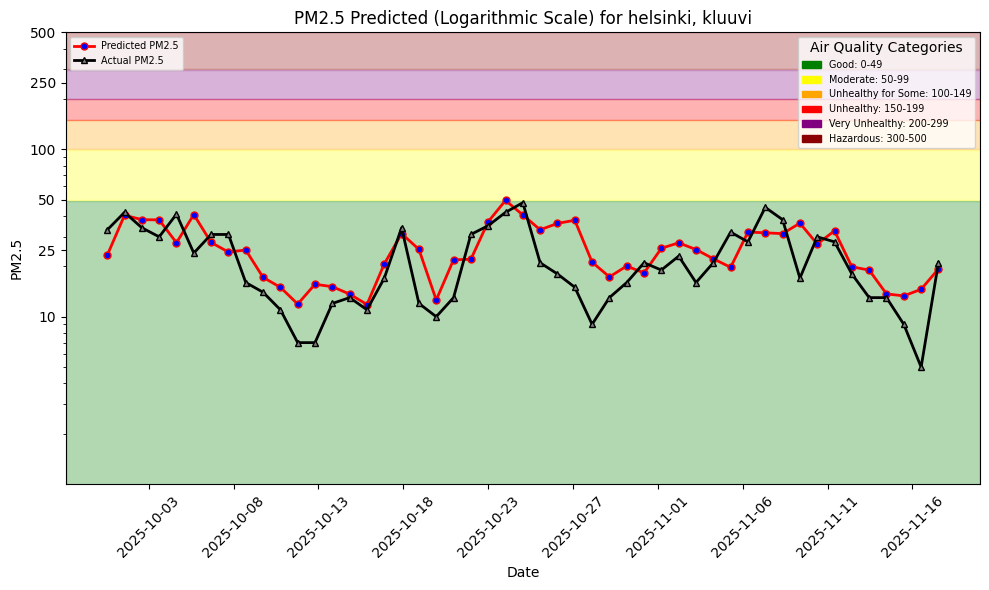

Saved hindcast plot for kluuvi to air_quality_model/images/pm25_hindcast_kluuvi.png


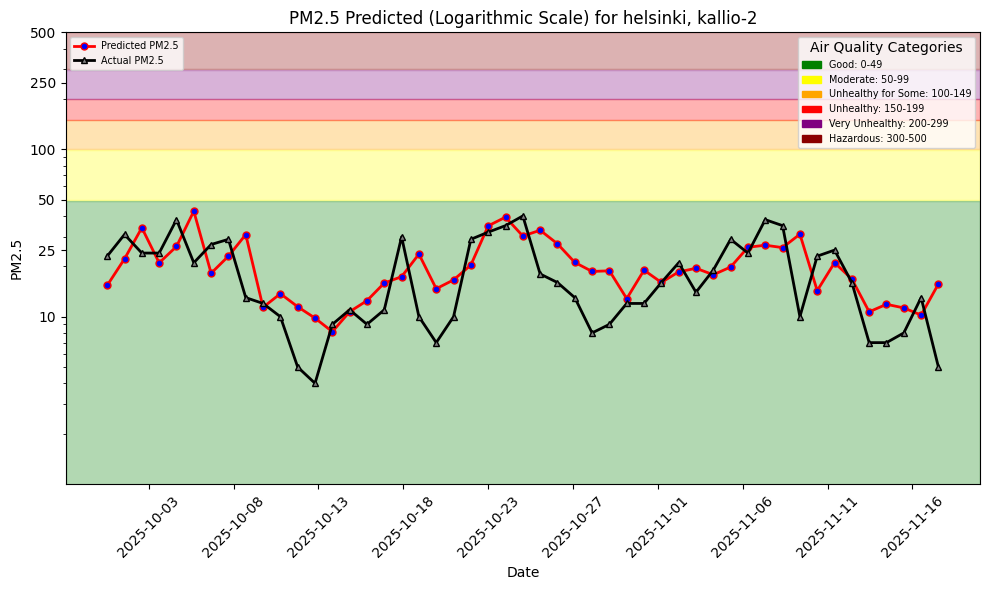

Saved hindcast plot for kallio-2 to air_quality_model/images/pm25_hindcast_kallio_2.png


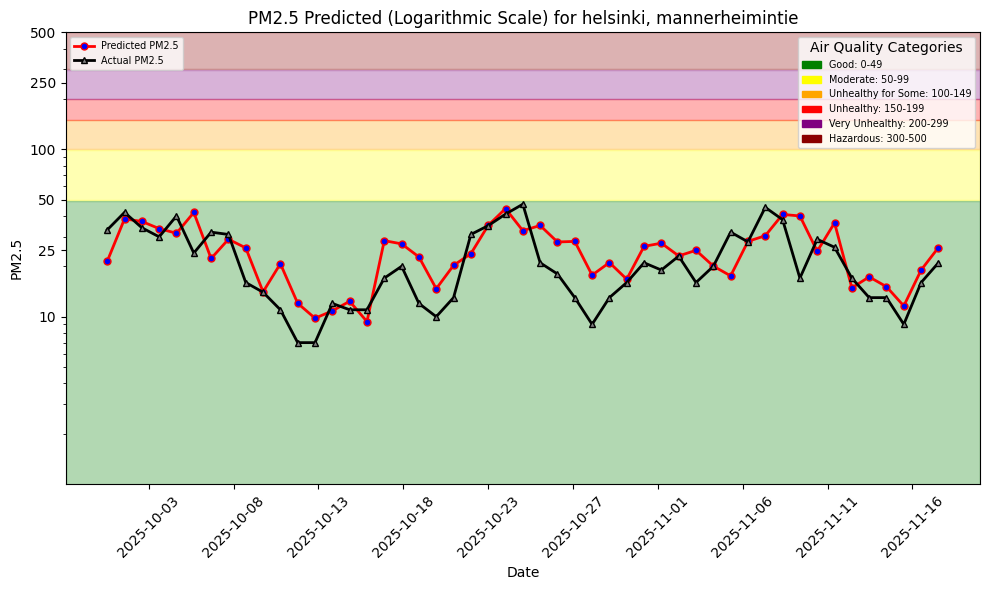

Saved hindcast plot for mannerheimintie to air_quality_model/images/pm25_hindcast_mannerheimintie.png


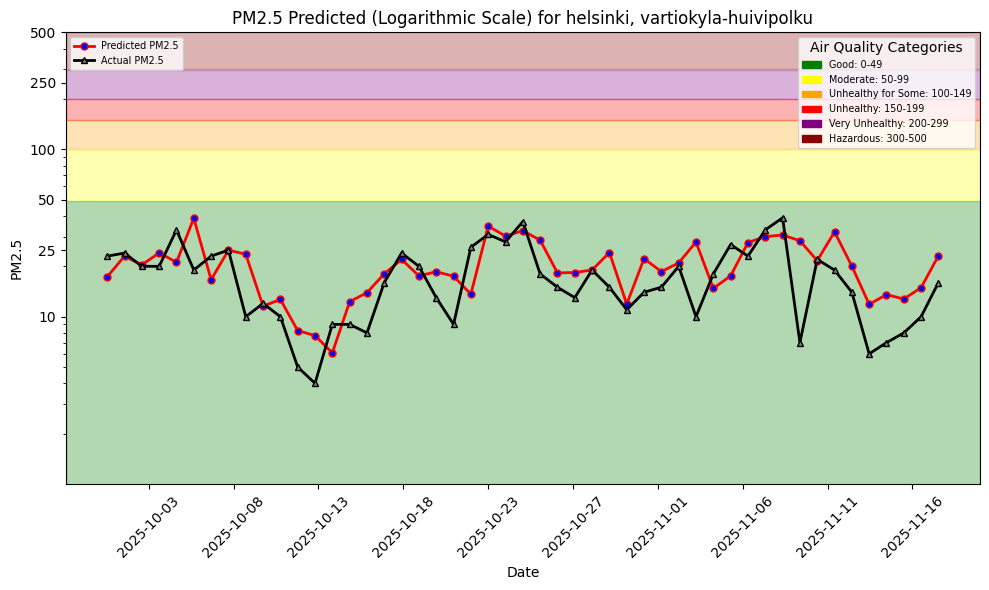

Saved hindcast plot for vartiokyla-huivipolku to air_quality_model/images/pm25_hindcast_vartiokyla_huivipolku.png


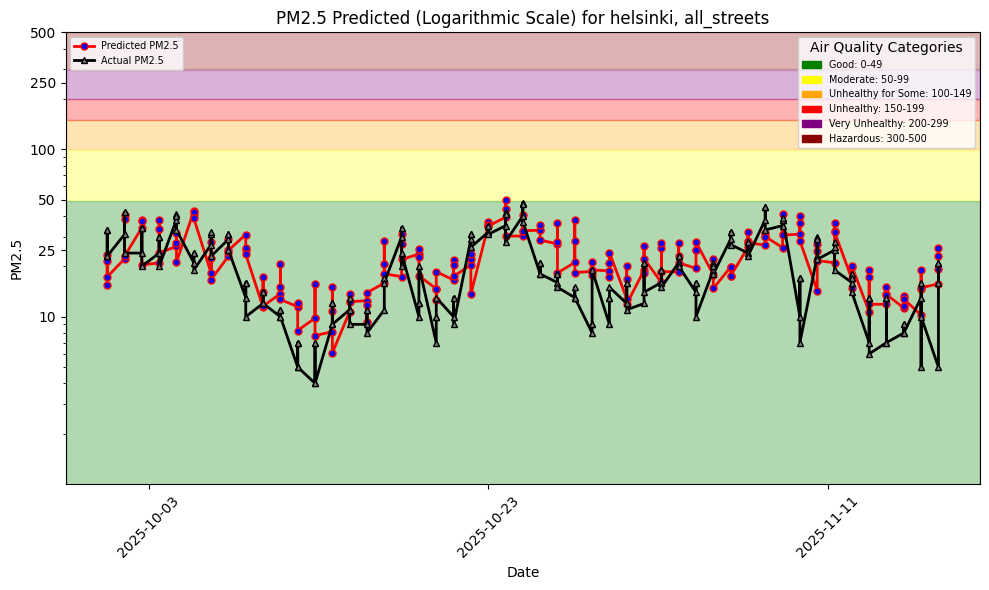

In [ ]:
# Plot hindcast for each street separately
for street in unique_streets:
    df_street = df[df['street'] == street].copy()
    df_street = df_street.sort_values(by=['date'])
    
    # Use street name in filename and directory
    street_safe = street.replace('-', '_')
    street_images_dir = f"{model_dir}/{street_safe}/images"
    file_path = f"{street_images_dir}/pm25_hindcast_{street_safe}.png"
    plt = util.plot_air_quality_forecast(city, street, df_street, file_path, hindcast=True) 
    plt.show()
    
    print(f"Saved hindcast plot for {street} to {file_path}")

# # Also create a combined plot with all streets
# file_path = images_dir + "/pm25_hindcast_helsinki_all_streets.png"
# df_sorted = df.sort_values(by=['date', 'street'])
# # For combined plot, use first street's name (or create a custom visualization)
# plt = util.plot_air_quality_forecast(city, "all_streets", df_sorted, file_path, hindcast=True) 
# plt.show()

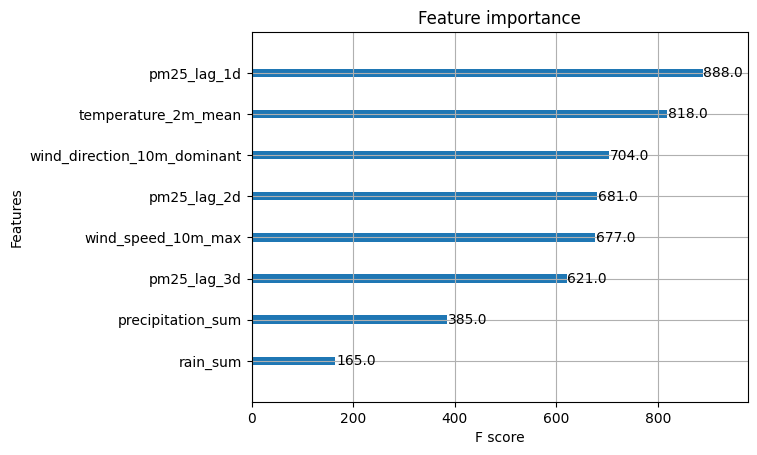

Saved feature importance plot for kluuvi to air_quality_model/images/feature_importance_kluuvi.png


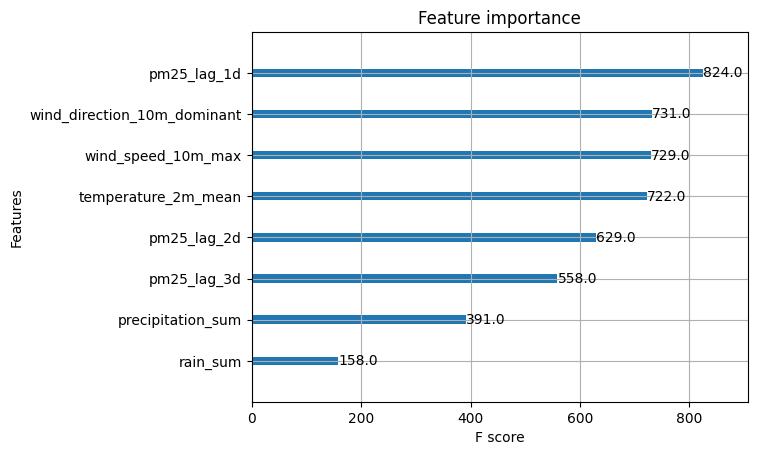

Saved feature importance plot for kallio-2 to air_quality_model/images/feature_importance_kallio_2.png


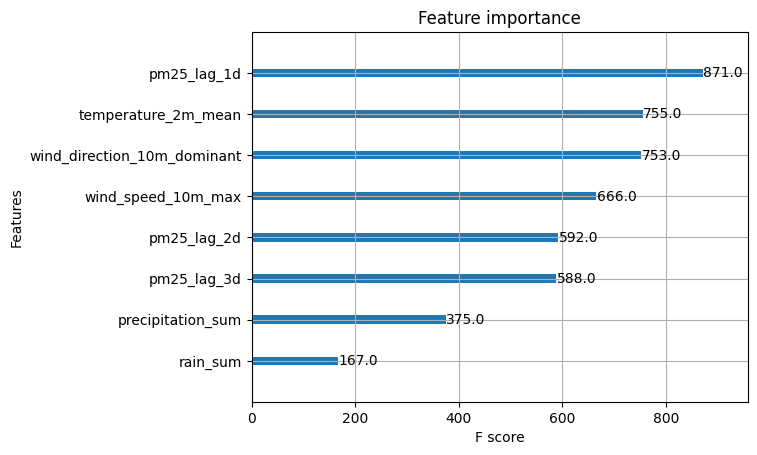

Saved feature importance plot for mannerheimintie to air_quality_model/images/feature_importance_mannerheimintie.png


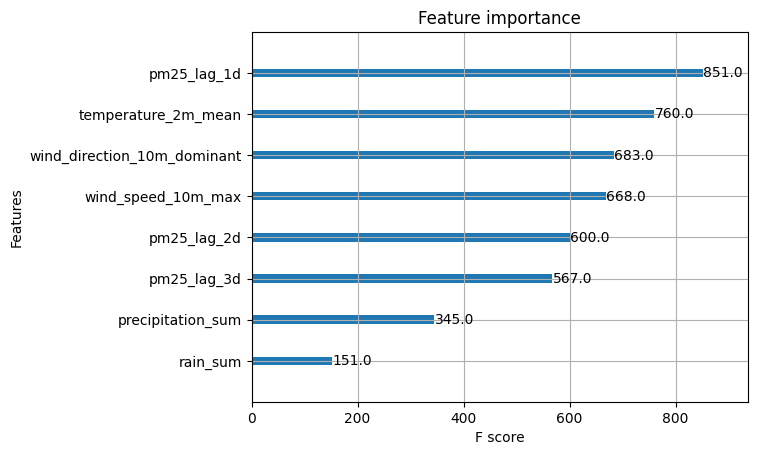

Saved feature importance plot for vartiokyla-huivipolku to air_quality_model/images/feature_importance_vartiokyla_huivipolku.png


In [ ]:
# Plotting feature importances for each street's model
for street in unique_streets:
    xgb_regressor = street_models[street]['model']
    plot_importance(xgb_regressor)
    
    street_safe = street.replace('-', '_')
    street_images_dir = f"{model_dir}/{street_safe}/images"
    feature_importance_path = f"{street_images_dir}/feature_importance_{street_safe}.png"
    plt.savefig(feature_importance_path)
    plt.show()
    
    print(f"Saved feature importance plot for {street} to {feature_importance_path}")

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [ ]:
# Saving each street's XGBoost model as a separate json file
for street in unique_streets:
    xgb_regressor = street_models[street]['model']
    street_safe = street.replace('-', '_')
    street_model_dir = f"{model_dir}/{street_safe}"
    model_path = f"{street_model_dir}/model_{street_safe}.json"
    xgb_regressor.save_model(model_path)
    print(f"Saved model for {street} to {model_path}")

Saved model for kluuvi to air_quality_model/model_kluuvi.json
Saved model for kallio-2 to air_quality_model/model_kallio_2.json
Saved model for mannerheimintie to air_quality_model/model_mannerheimintie.json
Saved model for vartiokyla-huivipolku to air_quality_model/model_vartiokyla_huivipolku.json


In [35]:
# Create metrics dictionary for each street model
street_metrics_dict = {}
for street in unique_streets:
    y_test_street = street_models[street]['y_test'].iloc[:, 0]
    y_pred_street = street_predictions[street]
    
    street_mse = mean_squared_error(y_test_street, y_pred_street)
    street_r2 = r2_score(y_test_street, y_pred_street)
    
    street_metrics_dict[street] = {
        "MSE": str(street_mse),
        "R squared": str(street_r2),
    }

# Also keep overall metrics
res_dict = {
    "overall_MSE": str(overall_mse),
    "overall_R_squared": str(overall_r2),
}

In [ ]:
mr = project.get_model_registry()

# Create a separate model in the registry for each street
street_models_registry = {}

for street in unique_streets:
    street_safe = street.replace('-', '_')
    model_name = f"air_quality_helsinki_xgboost_model_{street_safe}"
    
    # Use the existing street-specific directory structure
    street_model_dir = f"{model_dir}/{street_safe}"
    
    # Create model in registry
    aq_model = mr.python.create_model(
        name=model_name,
        metrics=street_metrics_dict[street],
        feature_view=feature_view,
        description=f"Air Quality (PM2.5) predictor for {street}, {city}",
    )
    
    # Save the model artifacts (model and images are already in the correct directory)
    aq_model.save(street_model_dir)
    street_models_registry[street] = aq_model
    
    print(f"Saved model for {street} to registry: {model_name}")
    print(f"  Explore at: {aq_model.url if hasattr(aq_model, 'url') else 'N/A'}")

print(f"\nSuccessfully registered {len(street_models_registry)} separate models in the registry")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_kluuvi/model_kluuvi.json: 0…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_kluuvi/images/feature_impor…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/model_schema.json: 0.000%|          | 0/925 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279136/models/air_quality_helsinki_xgboost_model_kluuvi/1
Saved model for kluuvi to registry: air_quality_helsinki_xgboost_model_kluuvi
  Explore at: N/A


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_kallio_2/model_kallio_2.jso…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_kallio_2/images/feature_imp…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/model_schema.json: 0.000%|          | 0/925 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279136/models/air_quality_helsinki_xgboost_model_kallio_2/1
Saved model for kallio-2 to registry: air_quality_helsinki_xgboost_model_kallio_2
  Explore at: N/A


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_mannerheimintie/model_manne…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_mannerheimintie/images/feat…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/model_schema.json: 0.000%|          | 0/925 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279136/models/air_quality_helsinki_xgboost_model_mannerheimintie/1
Saved model for mannerheimintie to registry: air_quality_helsinki_xgboost_model_mannerheimintie
  Explore at: N/A


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_vartiokyla_huivipolku/model…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/air_quality_model_vartiokyla_huivipolku/image…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/model_schema.json: 0.000%|          | 0/925 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279136/models/air_quality_helsinki_xgboost_model_vartiokyla_huivipolku/1
Saved model for vartiokyla-huivipolku to registry: air_quality_helsinki_xgboost_model_vartiokyla_huivipolku
  Explore at: N/A

Successfully registered 4 separate models in the registry


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
